In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Lectura de bases de datos

In [3]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.agregar_anio_mes_dia(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")


In [4]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.agregar_anio_mes_dia(df_procedimientos, "fecha_realizacion")
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

fecha_minimo_procedimientos = min(df_procedimientos.fecha_realizacion)
fecha_maximo_procedimientos = max(df_procedimientos.fecha_realizacion)

cols_texto = df_procedimientos.select_dtypes(include="object").apply(lambda x: x.str.strip())
df_procedimientos.loc[:, cols_texto.columns] = cols_texto


## Analisis de cantidad de consultas y procedimientos

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-02 00:00:00 y  2022-08-31 00:00:00


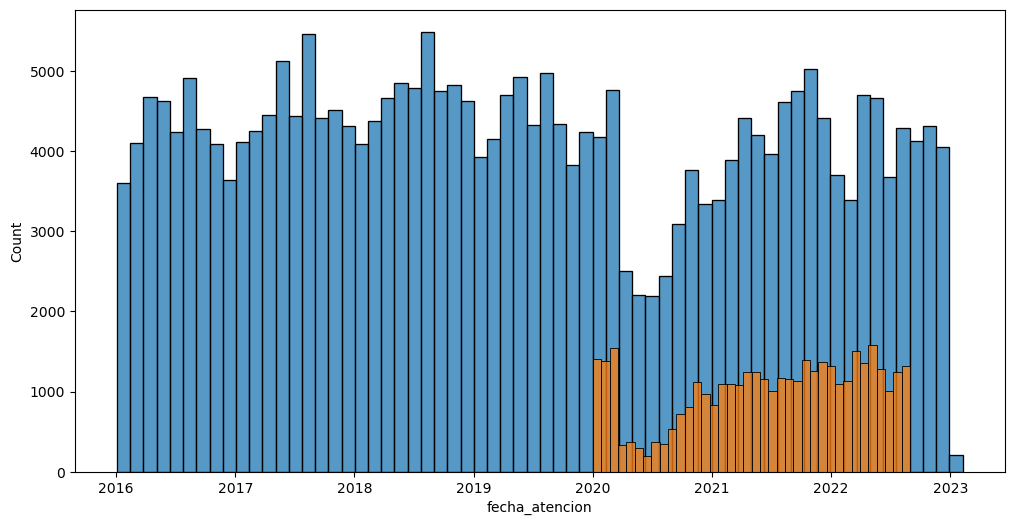

In [5]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
print(
    f"El rango de fechas de procedimientos es entre {fecha_minimo_procedimientos} y "
    f" {fecha_maximo_procedimientos}"
)

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()


- Por lo tanto, ambas bases deben estar con el mismo rango temporal. Se procedera a filtrar
la base de diagnosticos

In [6]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_minimo_procedimientos) & (
    df_diagnosticos["fecha_atencion"] <= fecha_maximo_procedimientos
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]


La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39484 procedimientos


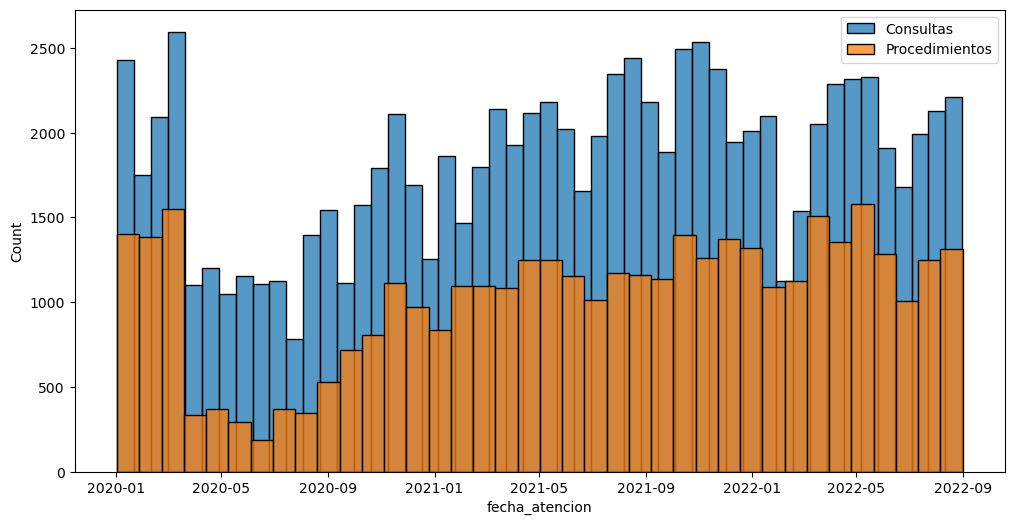

In [7]:
print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()


- Luego, se eliminaran todos los registros que carezcan de una fecha de consulta o procedimientos

In [8]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")


La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39472 procedimientos


- Por lo tanto, la base de consultas carecia de fechas de atencion faltantes. Sin embargo, la
base de procedimientos presentaba 33 fechas faltantes.

# Analisis a lo largo del tiempo

En este analisis se quieren obtener los siguientes insights:

- Frecuencia de diagnosticos por anio
- Rango etario por anio
- Sexo por anio

Ademas, se quieren obtener las siguientes variables para los pacientes

- Prevision
- Servicio de Salud
- Comuna

Para esto, se utilizara la base de datos estadisticos y se uniran en base al id del paciente

In [9]:
datos_pacientes = (
    df_procedimientos.value_counts(
        ["id_paciente", "comuna_residencia", "prevision", "servicio_salud"]
    )
    .reset_index()
    .drop(columns=0)
)

indices_pacientes_unicos = datos_pacientes.groupby("id_paciente").head(1).index
pacientes_unicos = datos_pacientes.iloc[indices_pacientes_unicos]


In [10]:
df_diagnosticos_datos_paciente = pd.merge(
    df_diagnosticos, pacientes_unicos, how="left", on="id_paciente"
)


In [11]:
agrupacion_estatica = ["ano"]
variable_a_contar = "codigo_diagnostico"

vars_a_obtener_detalle = [
    "sexo",
    "rango_etario_primera_consulta",
    "comuna_residencia",
    "prevision",
    "servicio_salud",
]


In [12]:
resultado_sociodemo = build_features.obtener_desglose_sociodemografico(
    df_diagnosticos_datos_paciente, agrupacion_estatica, vars_a_obtener_detalle, variable_a_contar
)

In [13]:
with pd.ExcelWriter(
    "../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx"
) as file:
    for nombre_hoja, df_a_guardar in resultado_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

# Analisis de procedimientos y diagnosticos

- En este apartado se quiere realizar un analisis de cuales procedimientos se le realizan a cada
diagnostico en ambulatorios. La primera forma de resolverlo es de la siguiente forma:

## 2. Obtener el diagnostico del paciente y llevarlo a los procedimientos

- La idea es enlazar solamente por ID_paciente el procedimiento/diagnostico. Sin embargo, un mismo
paciente puede tener diversos diagnosticos a lo largo del tiempo. Debido a lo anterior, es que se
necesita identificar el diagnostico que este mas cerca de la fecha del procedimiento

- Primero se debe saber si es que todos los pacientes de procedimientos estan en diagnosticos:

In [14]:
pacientes_consultas = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_procedimientos = set(df_procedimientos.id_paciente.unique())
diferencia_pacientes_consultas = pacientes_consultas - pacientes_procedimientos
diferencia_pacientes_procedimientos = pacientes_procedimientos - pacientes_consultas
pacientes_en_ambas = pacientes_consultas & pacientes_procedimientos

print(f"> La base de consultas tiene {len(pacientes_consultas)} pacientes distintos")
print(f"> La base de procedimientos tiene {len(pacientes_procedimientos)} pacientes distintos\n")
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
    f"en las consultas"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
    f" en procedimientos\n"
)
print(f"> Hay {len(pacientes_en_ambas)} pacientes que estan en ambas bases de datos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 14737 pacientes distintos

> Hay una diferencia de 11020 pacientes que solo estan en las consultas
> Hay una diferencia de 2544 pacientes que solo estan en procedimientos

> Hay 12193 pacientes que estan en ambas bases de datos


- La diferencia entre pacientes puede ocurrir debido a que ninguno de estos se ha hecho algun
procedimiento durante su consulta.

- Para reducir el costo computacional, se dejaran solamente los pacientes que esten en ambas bases
de datos

In [15]:
diags_pacientes_comunes = df_diagnosticos_acotado[
    df_diagnosticos_acotado.id_paciente.isin(pacientes_en_ambas)
]
proced_pacientes_comunes = df_procedimientos[df_procedimientos.id_paciente.isin(pacientes_en_ambas)]


- Ahora, en la base de procedimientos se deben obtener las duplas unicas entre id_paciente y
fecha_realizacion para reducir el costo computacional en la busqueda.

In [16]:
dupla_pacientes = (
    proced_pacientes_comunes[["id_paciente", "fecha_realizacion"]].value_counts().index
)

In [17]:
resultados_pacientes = []
for id_paciente, fecha_procedimiento in dupla_pacientes:
    df_paciente = diags_pacientes_comunes.query("id_paciente == @id_paciente")
    diag_mas_cercano = build_features.obtener_diag_mas_cercano(df_paciente, fecha_procedimiento)
    resultados_pacientes.append(diag_mas_cercano)


In [18]:
pacientes_y_diags = pd.DataFrame(resultados_pacientes, index=dupla_pacientes)
pacientes_y_diags.columns = ["codigo_diagnostico"]
proced_comunes_indice = proced_pacientes_comunes.set_index(["id_paciente", "fecha_realizacion"])
union_procedimientos_2 = pd.merge(
    proced_comunes_indice, pacientes_y_diags, how="inner", left_index=True, right_index=True
).reset_index()
